# Performance Optimization

## Multithreading & Multiprocessing
Both multithreading and multiprocessing aim to run multiple pieces of code at the same time to make the whole program execute quicker, to keep a program responsive during long computations or to distribute computations.

![](multithreading-vs-multiprocessing.jpg)

Python is a hard language to make multithreaded, mostly because of the **global interpreter lock** (GIL): Python is an interpreted language, and if the interpreter runs in only one thread, all the nice threads you're producing also run in only one thread.  
While multi*processing* finds a way around that, even multithreading can still be of use. While multithreading can, in Python, not be **parallel**, it can still be **concurrent**. 
* *parallel* processes run truly at the same time - meaning that they must run sumultaneously on different CPU-cores
* *concurrent* processes appear to be parallel to most of the system, even though the CPU may handle them one after another (either parallel or interlocked)

While CPU-intense processes are only truly sped up when they are parallel (something where Python's multithreading doesn't help), tasks that have a bottleneck in network or disk access are helped greatly from cuncurrent execution already.

In [25]:
import sys

a = []
b = a
print(sys.getrefcount(a))

b = None
print(sys.getrefcount(a))

3
2


Without the GIL Python couldn't be sure about the reference count of variables, leading to memory leaks or too early memory clean up.

## Multithreading

For the computer a process contains lots of information:
* State of the process (ready, running, inactive)
* Program-counter (next commands)
* CPU registers (cashed)
* Scheduling information (priority, position)
* Storage information
* I/O-Status
* ...

When switching processes, everything needs to be saved such that the CPU can load another process and freeze this one. This produces a lot of overhead. 

**Threads** are lightweight processes, using *shared resources*:
* Shared storage space
* Shared program code
* Shared (virtual) files.

Modern operating systems use threads to let programs switch control, without all the overhead of having to save and load all the information.   

| Advantages | Disadvantages |
|---|---|
| Much faster creation and task switching  | Operating system doesn't schedule them, harder to synchronize than processes  |
| Efficient communication between threads (unlike processes)  | Processes are better isolated  |
| Operating system doesn't schedule them, processes can implement their own scheduling  | Crashing Thread = Crashing Program  |
|   | **Python can't use them for parallel processing** |

In [2]:
import numpy as np
import time

The `threading` module can be used to work with threads in Python, even though most of the time this will not make anything faster.\
To create a thread, we have to call the constructor of the `threading.Thread` class. We can also use this class as a superclass if we want to create an own thread object in which we implement the functionality.\
To the `Thread` constructor, we pass a target function which will be executed in the separate thread. The args parameter will be forwarded to our target function when it is executed. Additionally, we can specify a name for the thread and set it as a daemon thread.\
Daemon threads are threads which can't keep the process running after all other non-daemon threads have finished. So if a process has only daemon threads left, it will end. By default, Python Thread objects inherit their daemonic property from the current thread so if we invoke a thread on the main thread, the new one will not be a daemon, since the main thread is not a daemon.

In [3]:
import threading

def hello(name):
    for _ in range(20):
        print(f'Oh hi {name}!')
        time.sleep(1)

thread = threading.Thread(target=hello, args=('Mark',), name='Steve-the-friendly-Thread', daemon=True)
thread

<Thread(Steve-the-friendly-Thread, initial daemon)>

To start the thread we have to call its `start` method. This will actually create the new thread and run the target function.

In [4]:
thread.start()
time.sleep(2)

Oh hi Mark!
Oh hi Mark!
Oh hi Mark!


We can do things on the main thread while the new thread is still running.

In [5]:
print('Hello')
time.sleep(2)

Hello
Oh hi Mark!
Oh hi Mark!


When we want the current thread to wait until another thread has finished, we call the `join` function on the thread object we want to wait for.

In [6]:
thread.join()
print('Done')

Oh hi Mark!
Oh hi Mark!
Oh hi Mark!
Oh hi Mark!
Oh hi Mark!
Oh hi Mark!
Oh hi Mark!
Oh hi Mark!
Oh hi Mark!
Oh hi Mark!
Oh hi Mark!
Oh hi Mark!
Oh hi Mark!
Oh hi Mark!
Oh hi Mark!
Done


As an example, we have a function that just counts down from a high number.

In [7]:
def countdown(index, n=1_000_000):
    while n > 0:
        n -= 1
    print(f'Countdown {index} finished')
    
countdown_times = {}

Here we just execute the function 3 times in a row to see how long this takes with a single thread.

In [8]:
start = time.time()

for i in range(5):
    countdown(i)
    
countdown_times['sequential'] = time.time() - start
print(f'This took {countdown_times["sequential"]} seconds')

Countdown 0 finished
Countdown 1 finished
Countdown 2 finished
Countdown 3 finished
Countdown 4 finished
This took 0.2704489231109619 seconds


Now we are creating three separate threads and run them concurrently to test if threads make counting down faster.\
As we can see the threads make counting down even slower. This is because we have some overhead when creating threads.

In [9]:
start = time.time()
threads = []
for i in range(5):
    threads.append(threading.Thread(target=countdown, args=(i,)))
    threads[-1].start()

for t in threads:
    t.join()

countdown_times['multithreaded'] = time.time() - start
print(f'This took {countdown_times["multithreaded"]} seconds')

Countdown 0 finished
Countdown 3 finished
Countdown 2 finished
Countdown 1 finished
Countdown 4 finished
This took 0.3942840099334717 seconds


Now let's try the same but with sleeping instead of counting down.

In [10]:
def sleep(index):
    time.sleep(2)
    print(f'Number {index} finished sleeping')
    
sleep_times = {}

When sleeping 5 times for 2 seconds a single thread will take 10 seconds of course.

In [11]:
start = time.time()
for i in range(5):
    sleep(i)
    
sleep_times['sequential'] = time.time() - start
print(f'This took {sleep_times["sequential"]} seconds')

Number 0 finished sleeping
Number 1 finished sleeping
Number 2 finished sleeping
Number 3 finished sleeping
Number 4 finished sleeping
This took 10.011039733886719 seconds


But this is our threads' time to shine, they are able to sleep in parallel. "Sleeping" does not mean that the CPU does nothing, the one "sleeping" is the thread itself, meaning it does not request the CPU to do anything. This allows multiple threads to sleep in parallel even with the GIL as a sleeping thread does not run any code.

In [12]:
start = time.time()
threads = []
for i in range(5):
    threads.append(threading.Thread(target=sleep, args=(i,)))
    threads[-1].start()

for t in threads:
    t.join()
    
sleep_times['multithreaded'] = time.time() - start
print(f'This took {sleep_times["multithreaded"]} seconds')

Number 0 finished sleeping
Number 1 finished sleeping
Number 2 finished sleeping
Number 3 finished sleeping
Number 4 finished sleeping
This took 2.007768154144287 seconds


## Multiprocessing
To really run Python code in parallel we can use the `multiprocessing` module. This allows us to create new Python processes with separate memory and own interpreters and therefore also a different interpreter lock. This is achieved by copying the memory of the current process to a new subprocess. Note however that the amount of memory with some additional overhead increased with the amount of subprocesses. Therefore it can be much more efficient because it can really leverage the multi-core performance of CPUs.

### Processes
The `multiprocessing.Process` class has a very similar interface as the `threading.Thread` class but it will create subprocess instead of a thread. It is important to close these processes when you don't need them anymore because otherwise they will just keep running even after the main thread has stopped. If you don't close them you can either stop them manually in the task manager or by restarting the computer. It is better practice to use the `with` statement to create a subprocess because this will automatically clean up afterwards.

In [13]:
from multiprocessing import Process

Let's have a look at the countdown example again.

In [14]:
start = time.time()
processes = []
for i in range(5):
    processes.append(Process(target=countdown, args=(i,)))
    processes[-1].start()

for p in processes:
    p.join()
    # it is important to close these subprocesses after they finished, otherwise they will just keep running on the computer
    p.close()
    
countdown_times['multiprocess'] = time.time() - start
print(f'This took {countdown_times["multiprocess"]} seconds')

Countdown 2 finished
Countdown 0 finished
Countdown 1 finished
Countdown 3 finished
Countdown 4 finished
This took 0.14782023429870605 seconds


The multithreaded version actually was slower than the sequential one (due to overhead) but the multiprocessing approach was able to run about twice as fast as the sequential version.

We have spawned five subprocesses though, why wasn't it five times faster? This is, again, due to overhead when creating the subprocesses and copying the memory over.

In [15]:
countdown_times

{'sequential': 0.2704489231109619,
 'multithreaded': 0.3942840099334717,
 'multiprocess': 0.14782023429870605}

Looking at the sleep example again, the multiprocessing approach is about as fast as the multithreading approach so the overhead in such a small toy example does not really differ but this might change when you have to copy over massive amounts of data to new subprocesses.

In [16]:
start = time.time()
processes = []
for i in range(5):
    processes.append(Process(target=sleep, args=(i,)))
    processes[-1].start()

for p in processes:
    p.join()
    p.close()
    
sleep_times['multiprocessing'] = time.time() - start
print(f'This took {sleep_times["multiprocessing"]} seconds')

Number 0 finished sleeping
Number 1 finished sleeping
Number 2 finished sleepingNumber 3 finished sleeping
Number 4 finished sleeping

This took 2.0276758670806885 seconds


In [17]:
sleep_times

{'sequential': 10.011039733886719,
 'multithreaded': 2.007768154144287,
 'multiprocessing': 2.0276758670806885}

### Pools
In addition to the `Process` class the multiprocessing module also offers a `Pool` class which can be used to spawn multiple subprocesses that can be reused. Since processes work on the actual CPU cores, you will not gain any further performance by creating more subprocesses than you have CPU cores. You can specify how many subprocesses the pool should create using the `processes` parameter. By default this will be set to `multiprocessing.cpu_count()` which returns the number of CPU cores (in some cases it is not the number of physical cores but the number of [CPU threads](https://en.wikipedia.org/wiki/Hyper-threading) but for the sake of simplicity I will refer to these as cores) available in your system.

`Pool` objects support asynchronous and blocking calls to apply and map. Asynchronous means that it doesn't block the execution of the invoking thread, it just calls a callback function as soon as it is done. Blocking on the other hand means that it will stop the current process and wait for the pool to finish. It works more like the traditional apply and map functions from Python lists.

In [18]:
from multiprocessing import Pool, cpu_count
print(f'Number of CPU cores in this computer: {cpu_count()}')

Number of CPU cores in this computer: 8


Let's see if we can make this really inefficient way of summing up the values in an n-dimensional array faster using a multiprocessing pool.

In [19]:
def expensive(x):
    result = 0
    for i, j in np.ndindex(x.shape):
        result += x[i,j]
    return result

# generate some numbers to map the function on
nums = np.arange(10_000_000).reshape(-1, 100, 100)
nums.shape

(1000, 100, 100)

First of all, how long does it take to run this sequentially.

In [20]:
start = time.time()
result = list(map(expensive, nums))
print(f'This took {time.time() - start} seconds')

This took 8.012200117111206 seconds


Now let's see how much faster this gets when we use a `Pool`.

In [21]:
start = time.time()
with Pool() as p:
    result = p.map(expensive, nums)
print(f'This took {time.time() - start} seconds')

This took 2.7576920986175537 seconds


## Higher-level multithreading and multiprocessing
The joblib library offers a high-level interface to both multithreading and multiprocessing using multiple backends for parallelizing for-loops. By default, it uses the so called "loky" backend which is a very efficient implementation of multiprocessing in Python. To parallelize for loops we need two things from the library: `Parallel` and `delayed`. The `Parallel` class is a lot like the pool from the multiprocessing library but it supports different backends which allow you to use multithreading or multiprocessing. `delayed` is a decorator which can be used to mark the function that should be executed in parallel.

In [6]:
from joblib import Parallel, delayed
from tqdm.notebook import tqdm

The syntax might be a little weird at first but actually it is pretty much like a list comprehension. Print statements inside the parallelized function will only work if `n_jobs` is set to 1 (no parallelization). This allows you to debug when something does not work as expected.

In [23]:
@delayed
def square(x):
    print(f'Squaring {x}...')
    return x ** 2

result = Parallel(n_jobs=3)(square(x) for x in tqdm(range(10)))
result

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]

In [24]:
def eigvals(mat):
    return np.linalg.eigvals(mat)

@delayed
def eigvals_delayed(mat):
    return np.linalg.eigvals(mat)

nums.shape

(1000, 100, 100)

Let's see how long the multiprocessing module takes to compute the eigenvalues of many matrices.

In [26]:
start = time.time()

with Pool() as p:
    result = p.map(eigvals, nums)
    
print(f'This took {time.time() - start} seconds')

This took 5.343011856079102 seconds


And in comparison to that joblib using the loky backend.

In [27]:
start = time.time()

result = Parallel(n_jobs=-1)(eigvals_delayed(x) for x in tqdm(nums))

print(f'This took {time.time() - start} seconds')


This took 1.9565415382385254 seconds


And now the same call but using the threading backend. This should be the slowest as Python's threads don't really run in parallel.

In [28]:
start = time.time()

result = Parallel(n_jobs=-1, backend='threading')(eigvals_delayed(x) for x in tqdm(nums))

print(f'This took {time.time() - start} seconds')


This took 16.307597637176514 seconds


## Serialization
How do the `multiprocessing` and `joblib` modules actually copy the memory? This is done efficiently using serialization or in other words translating an object into a format that is easy to store away in a file or transmit. In Python this can be done using the `pickle` module, which takes a Python object and gives you a binary representation of this object which can be used to save it to a file or copy it to another process.

In [29]:
import pickle

In [30]:
class Animal:
    def __init__(self, name, n_legs, fluffy, running_speed):
        self.name = name
        self.n_legs = n_legs
        self.fluffy = fluffy
        self.running_speed = running_speed
        
    def __repr__(self):
        return f'{self.name} is a {"fluffly" if self.fluffy else "not so fluffy"} animal with {self.n_legs} legs and is able to run {self.running_speed} km/h'
    
a1 = Animal('Cowy', 4, True, 15)
a2 = Animal('Spidery', 8, False, 0.2)
a3 = Animal('Monkey', 2, True, 13)
a1, a2, a3

(Cowy is a fluffly animal with 4 legs and is able to run 15 km/h,
 Spidery is a not so fluffy animal with 8 legs and is able to run 0.2 km/h,
 Monkey is a fluffly animal with 2 legs and is able to run 13 km/h)

`pickle.dumps` returns a bytes object with binary data. We could use this to pass it to another process, save it to a file or transmit it over the internet.

In [31]:
a1_bin = pickle.dumps(a1)
a1_bin

b'\x80\x03c__main__\nAnimal\nq\x00)\x81q\x01}q\x02(X\x04\x00\x00\x00nameq\x03X\x04\x00\x00\x00Cowyq\x04X\x06\x00\x00\x00n_legsq\x05K\x04X\x06\x00\x00\x00fluffyq\x06\x88X\r\x00\x00\x00running_speedq\x07K\x0fub.'

To restore the Python object from such the binary representation, we can use the `pickle.loads` function.

In [32]:
restored = pickle.loads(a1_bin)
print(type(restored))
restored

<class '__main__.Animal'>


Cowy is a fluffly animal with 4 legs and is able to run 15 km/h

We can also directly save it to a file using `pickle.dump` and load from a file using `pickle.load`.

In [33]:
with open('animals.pkl', 'wb') as file:
    pickle.dump([a1, a2, a3], file)

In [34]:
with open('animals.pkl', 'rb') as file:
    animals = pickle.load(file)
animals

[Cowy is a fluffly animal with 4 legs and is able to run 15 km/h,
 Spidery is a not so fluffy animal with 8 legs and is able to run 0.2 km/h,
 Monkey is a fluffly animal with 2 legs and is able to run 13 km/h]

## Compiling Python code

### Numba
Numba is an open source just-in-time (JIT) compiler that translates a subset of Python and NumPy code into fast machine code. Numba-compiled numerical algorithms in Python can approach the speeds of C. Instead of having to re-write or even re-compile your code, you just have to add one decorator to the function.

In [1]:
import numpy as np

def go_slow(a):
    trace = 0
    for i in range(a.shape[0]):   
        trace += np.tanh(a[i, i]) 
    return a + trace

print(go_slow(np.arange(100).reshape(10, 10)))

[[  9.  10.  11.  12.  13.  14.  15.  16.  17.  18.]
 [ 19.  20.  21.  22.  23.  24.  25.  26.  27.  28.]
 [ 29.  30.  31.  32.  33.  34.  35.  36.  37.  38.]
 [ 39.  40.  41.  42.  43.  44.  45.  46.  47.  48.]
 [ 49.  50.  51.  52.  53.  54.  55.  56.  57.  58.]
 [ 59.  60.  61.  62.  63.  64.  65.  66.  67.  68.]
 [ 69.  70.  71.  72.  73.  74.  75.  76.  77.  78.]
 [ 79.  80.  81.  82.  83.  84.  85.  86.  87.  88.]
 [ 89.  90.  91.  92.  93.  94.  95.  96.  97.  98.]
 [ 99. 100. 101. 102. 103. 104. 105. 106. 107. 108.]]


In [2]:
from numba import jit

@jit(nopython=True)
def go_fast(a):
    trace = 0
    for i in range(a.shape[0]):
        trace += np.tanh(a[i, i])
    return a + trace

In [3]:
x = np.arange(10_000).reshape(100, 100)
%time result = go_fast(x)

CPU times: user 341 ms, sys: 12.5 ms, total: 354 ms
Wall time: 354 ms


In [4]:
%%timeit
go_slow(x)

417 µs ± 16 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [5]:
%%timeit
go_fast(x)

9.54 µs ± 86 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


### Jax
Jax is a quite new library that is still under early development but it also offers a JIT compiler for Python code and on top of that is able to automatically differentiate your functions. For that it uses [Automatic Differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation) (AD), which computes the actual mathematically correct derivative of the function. It does not rely on numerical estimates and can therefore be a useful tool for gradient-based optimization.

The library has its own NumPy implementation which is necessary for the automatic differentiation to work. It can be imported with ```import jax.numpy as jnp```.

In [7]:
import jax.numpy as jnp
from jax import jit as jit_jax

@jit_jax
def go_jax(a):
    trace = 0
    for i in range(a.shape[0]):   
        trace += jnp.tanh(a[i, i]) 
    return a + trace

x_jax = jnp.arange(10_000).reshape(100, 100)

/home/philipp/conda/envs/scientific_programming/lib/python3.7/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


As you can see, it is not quite as fast as Numba's JIT compiler but this might change in the future when the library is further developed. Also, Numba is not able to compute derivatives of Python functions, which makes Jax useful in that regard.

In [8]:
%%timeit
go_jax(x_jax)

199 µs ± 68.5 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


To see how Jax' automatic differentiation works, let's look at the example of iteratively fitting a linear regression model to some data using the mean squared error. For this purpose we create some random linear data with a slope of 3 and an intercept of 1.

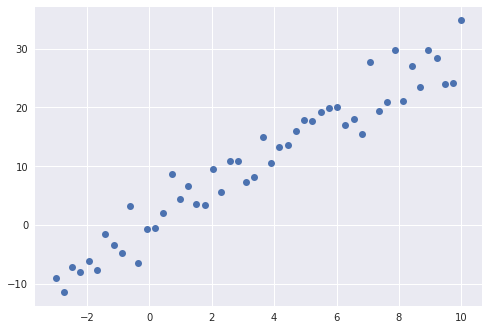

In [21]:
from matplotlib import pyplot as plt
plt.style.use('seaborn')

xs = np.linspace(-3, 10, 50)
ys = 3 * xs + 1 + np.random.normal(0, 3, size=len(xs))

plt.plot(xs, ys, 'o');

First of all we define the mean squared error function, taking the slope and intercept of the model, as well as the x- and y-values of our data.

In [22]:
@jit_jax
def mse(slope, intercept, xs, ys):
    return jnp.mean((xs * slope + intercept - ys) ** 2)

We get the gradient function by passing `mse` to the `grad` function and specifying which partial derivatives we want (`argnums` parameter with indices of positional arguments).

In [23]:
from jax import grad

mse_grad = grad(mse, argnums=(0, 1))

To optimize our slope and intercept we can use their partial derivatives which directly come from the `mse_grad` function.


Mean Squared Error: 8.933629
Fitted slope: 3.021932
Fitted intercept: 0.26965776


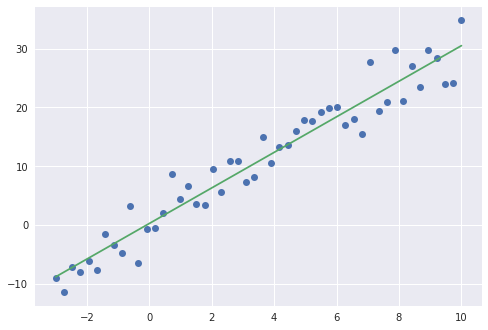

In [24]:
# initialize model
slope = 1.0
intercept = 0.0

# optimize using the gradient
for step in tqdm(range(500)):
    ds, di = mse_grad(slope, intercept, xs, ys)
    slope -= 0.001 * ds
    intercept -= 0.001 * di
    
print('Mean Squared Error:', mse(slope, intercept, xs, ys))
print('Fitted slope:', slope)
print('Fitted intercept:', intercept)

# show the result
plt.plot(xs, ys, 'o')
plt.plot(xs, xs * slope + intercept);

## Cython
One way to make your program run faster: compile to a faster language.
[https://cython.org/](https://cython.org/)

### About Cython

Cython is an optimising static compiler for both the Python programming language and the extended Cython programming language (based on Pyrex). It makes writing C extensions for Python as easy as Python itself.

Cython gives you the combined power of Python and C to let you

* write Python code that calls back and forth from and to C or C++ code natively at any point.
* easily tune readable Python code into plain C performance by adding static type declarations, also in Python syntax.
* use combined source code level debugging to find bugs in your Python, Cython and C code.
* interact efficiently with large data sets, e.g. using multi-dimensional NumPy arrays.
* quickly build your applications within the large, mature and widely used CPython ecosystem.
* integrate natively with existing code and data from legacy, low-level or high-performance libraries and applications.

The Cython language is a superset of the Python language that additionally supports calling C functions and declaring C types on variables and class attributes. This allows the compiler to generate very efficient C code from Cython code. The C code is generated once and then compiles with all major C/C++ compilers in CPython 2.6, 2.7 (2.4+ with Cython 0.20.x) as well as 3.3 and all later versions. We regularly run integration tests against all supported CPython versions and their latest in-development branches to make sure that the generated code stays widely compatible and well adapted to each version. PyPy support is work in progress (on both sides) and is considered mostly usable since Cython 0.17. The latest PyPy version is always recommended here.

All of this makes Cython the ideal language for wrapping external C libraries, embedding CPython into existing applications, and for fast C modules that speed up the execution of Python code. 

The fundamental nature of Cython can be summed up as follows: Cython is Python with C data types.

Cython is Python: Almost any piece of Python code is also valid Cython code. (There are a few Limitations, but this approximation will serve for now.) The Cython compiler will convert it into C code which makes equivalent calls to the Python/C API.

But Cython is much more than that, because parameters and variables can be declared to have C data types. Code which manipulates Python values and C values can be freely intermixed, with conversions occurring automatically wherever possible. Reference count maintenance and error checking of Python operations is also automatic, and the full power of Python’s exception handling facilities, including the try-except and try-finally statements, is available to you – even in the midst of manipulating C data.

For an introduction on how to use Cython, I recommend [https://cython.readthedocs.io/en/latest/src/tutorial/cython_tutorial.html](https://cython.readthedocs.io/en/latest/src/tutorial/cython_tutorial.html).